In [ ]:
!pip install gradio --quiet


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import gradio as gr


In [18]:
from google.colab import files
uploaded = files.upload()


df = pd.read_csv('LoanApprovalPrediction.csv')
df.head()


Saving LoanApprovalPrediction.csv to LoanApprovalPrediction (1).csv


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<Axes: xlabel='ApplicantIncome', ylabel='Count'>

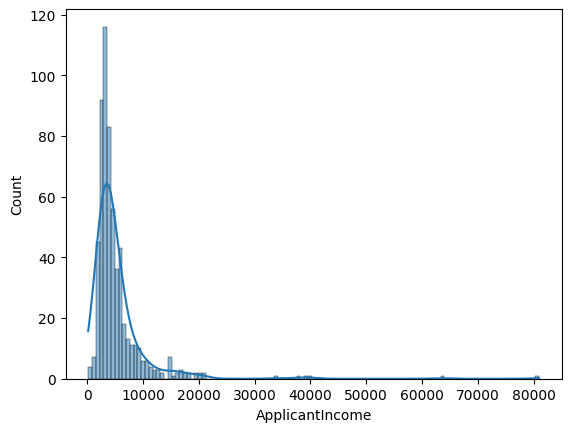

In [ ]:
import seaborn as sns
sns.histplot(df['ApplicantIncome'], kde=True)

In [ ]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df.drop('Loan_ID', axis=1, inplace=True)
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)


<ipython-input-6-bcb9e3e36bb6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
<ipython-input-6-bcb9e3e36bb6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [ ]:
df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})
df['Married'] = df['Married'].map({'Yes':1, 'No':0})
df['Education'] = df['Education'].map({'Graduate':1, 'Not Graduate':0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes':1, 'No':0})
df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})
df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)


In [ ]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['DTI'] = df['LoanAmount'] / df['TotalIncome']
df['LTI'] = df['LoanAmount'] / df['ApplicantIncome']


In [ ]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight={0: 1.5, 1: 1},
    random_state=42
)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

joblib.dump(model, 'loan_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'features.pkl')

Accuracy: 0.8083333333333333
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        35
           1       0.85      0.88      0.87        85

    accuracy                           0.81       120
   macro avg       0.77      0.76      0.76       120
weighted avg       0.80      0.81      0.81       120



['features.pkl']

In [ ]:
def predict_loan(Gender, Married, Dependents, Education, Self_Employed,
                 ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term,
                 Credit_History, Property_Area):

    TotalIncome = ApplicantIncome + CoapplicantIncome
    DTI = LoanAmount / TotalIncome
    LTI = LoanAmount / ApplicantIncome if ApplicantIncome != 0 else 0

    Gender = 1 if Gender == 'Male' else 0
    Married = 1 if Married == 'Yes' else 0
    Education = 1 if Education == 'Graduate' else 0
    Self_Employed = 1 if Self_Employed == 'Yes' else 0
    PA_Semiurban = 1 if Property_Area == 'Semiurban' else 0
    PA_Urban = 1 if Property_Area == 'Urban' else 0

    input_data = [Gender, Married, Dependents, Education, Self_Employed,
                  ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term,
                  Credit_History, PA_Semiurban, PA_Urban, TotalIncome, DTI, LTI]

    input_scaled = scaler.transform(np.array(input_data).reshape(1, -1))
    prediction = model.predict(input_scaled)
    return "Loan Approved ✅" if prediction[0] == 1 else "Loan Rejected ❌"





In [ ]:
demo = gr.Interface(
    fn=predict_loan,
    inputs=[
        gr.Radio(['Male', 'Female'], label="Gender"),
        gr.Radio(['Yes', 'No'], label="Married"),
        gr.Slider(0, 3, step=1, label="Dependents"),
        gr.Radio(['Graduate', 'Not Graduate'], label="Education"),
        gr.Radio(['Yes', 'No'], label="Self Employed"),
        gr.Number(label="Applicant Income"),
        gr.Number(label="Coapplicant Income"),
        gr.Number(label="Loan Amount"),
        gr.Number(label="Loan Amount Term"),
        gr.Radio([1.0, 0.0], label="Credit History"),
        gr.Radio(['Rural', 'Semiurban', 'Urban'], label="Property Area")
    ],
    outputs="text",
    title="Loan Approval Predictor",
    description="Enter applicant details to check loan eligibility"
)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f7ab487ef1bbd0c4c8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
